The goal of this assignment is to implement a logistic regression classifier using stochastic gradient ascent. You will:

- Extract features from Amazon product reviews.
- Convert an SFrame into a NumPy array.
- Write a function to compute the derivative of log likelihood function (with L2 penalty) with respect to a single coefficient.
- Implement stochastic gradient ascent with L2 penalty
- Compare convergence of stochastic gradient ascent with that of batch gradient ascent

In [1]:
import pandas as pd 
import numpy as np

In [2]:
products = pd.read_csv('amazon_baby_subset.csv')

important_words = pd.read_json('important_words.json', typ='series')

In [3]:
def remove_punctuation(text):
    import string
    import re
    
    punctuation=string.punctuation #list of puncts
    clean=re.sub(r"[{}]".format(punctuation),"",text)
    
    return clean

In [4]:
products=products.fillna({"review":""})

products['review_clean']=products['review'].apply(remove_punctuation)

for word in important_words:
    products[word] = products['review_clean'].apply(lambda s: s.split().count(word))

In [5]:
train_idx=pd.read_json('module-10-assignment-train-idx.json',typ='series')
valid_idx=pd.read_json('module-10-assignment-validation-idx.json',typ='series')

train = products.iloc[train_idx]
valid = products.iloc[valid_idx]

In [6]:
def get_data(dataframe, features, label):
    
    df=dataframe.copy()
    
    df.insert(0, 'constant', 1)
    features = ["constant"] + list(features)
    
    features_frame=df[features]
    feature_matrix=features_frame.as_matrix()
    
    label_sarray=df[label]
    label_array= label_sarray.as_matrix()
    
    return(feature_matrix, label_array)

In [7]:
X_train, y_train = get_data(train,important_words,'sentiment')

In [8]:
X_valid, y_valid = get_data(valid, important_words, 'sentiment')

In [9]:
def predict_probability(feature_matrix, coefficients):
    
    score=np.dot(feature_matrix,coefficients)
    prediction= 1. /(1 +np.exp(-score)) #link funcution
    
    return prediction

In [10]:
def feature_derivative(errors, feature):
    derivative=np.dot(errors, feature)
    
    return derivative

In [11]:
def avg_log_likelihood(X,y,coefficients):
    indicator = (y==1)
    scores = np.dot(X,coefficients)
    logexp = np.log(1 + np.exp(-scores))
    
    #check to prevent overflow
    mask = np.isinf(logexp)
    logexp[mask] = -scores[mask]
    
    lp=np.sum((indicator-1)*scores - logexp)/len(X)
    return lp

# Computing the gradient for a single data point



In [12]:
j=1
i=10

coef=np.zeros(194)
predictions =predict_probability(X_train[i:i+1,:], coef)
indicator= (y_train[i:i+1]==1)
errors=indicator - predictions

gradient_aingle_data_point = feature_derivative(errors, X_train[i:i+1,j])

print('Gradient single data point: {:.4f}'.format(gradient_aingle_data_point))
print('           --> should print 0.0')

Gradient single data point: 0.0000
           --> should print 0.0


# Modifying the derivative for using a batch of data points


In [13]:
j=1 #num feat
i=10 # data point start
B=10 # mini batch size
coef=np.zeros(194)

predictions = predict_probability(X_train[i:i+B,:], coef)
indicator = (y_train[i:i+B]==1)

errors = indicator - predictions

gradient_mini_batch = feature_derivative(errors, X_train[i:i+B,j])

print('Gradient single data point: {:.4f}'.format(gradient_mini_batch))
print('           --> should print 1.0')

Gradient single data point: 1.0000
           --> should print 1.0


# implement stochastic gradient descent

In [14]:
def logit_regression_SG(X, y, initial_coef, step_size, batch_size, max_iter, verbose=False):
    
    log_likelihood =[]
    W = np.array(initial_coef) #weights
    np.random.seed(1)
    
    #shuffle data
    permutation = np.random.permutation(len(X))
    X = X[permutation,:]
    y = y[permutation]
    
    i=0 #index batch
    for itr in range(max_iter):
        
        predictions = predict_probability(X[i:i+batch_size,:], W)
        indicator   = (y[i:i+batch_size]==1)
        errors      = indicator - predictions
        
        for j in range(len(W)): #loop over each W=coefficient
            
            derivative = feature_derivative(errors, X[i:i+batch_size,j])
            W[j]+=(1./batch_size)*(step_size*derivative)
            
        # check if log likehood is increasing
        lp = avg_log_likelihood(X[i:i+batch_size,:],y[i:i+batch_size], W)
        log_likelihood.append(lp)
        
        if verbose:
            if itr<=15 or (itr<=1000 and itr % 100==0) or (itr<=10000 and itr % 1000==0) or itr % 10000==0 or itr==max_iter-1:
                data_size = len(X)
                print('Iteration {}: average log likelihood of data points {}:{} = {:.8f}'.format(itr, i,batch_size, lp))

        
        #if complete pass over data is done, shuffle and restart
        i+=batch_size
        if i+batch_size > len(X):
            permutation = np.random.permutation(len(X))
            X=X[permutation,:]
            y=y[permutation]
            i=0
            
    return W, log_likelihood

In [15]:
sample_feature_matrix = np.array([[1.,2.,-1.], [1.,0.,1.]])
sample_sentiment = np.array([+1, -1])

coefficients, log_likelihood = logit_regression_SG(sample_feature_matrix, sample_sentiment, np.zeros(3),
                                                  step_size=1., batch_size=2, max_iter=2, verbose=True)
print('-------------------------------------------------------------------------------------')
print('Coefficients learned                 :', coefficients)
print('Average log likelihood per-iteration :', log_likelihood)
if np.allclose(coefficients, np.array([-0.09755757,  0.68242552, -0.7799831]), atol=1e-3)\
  and np.allclose(log_likelihood, np.array([-0.33774513108142956, -0.2345530939410341])):
    # pass if elements match within 1e-3
    print('-------------------------------------------------------------------------------------')
    print('Test passed!')
else:
    print('-------------------------------------------------------------------------------------')
    print('Test failed')

Iteration 0: average log likelihood of data points 0:2 = -0.33774513
Iteration 1: average log likelihood of data points 0:2 = -0.23455309
-------------------------------------------------------------------------------------
Coefficients learned                 : [-0.09755757  0.68242552 -0.7799831 ]
Average log likelihood per-iteration : [-0.33774513108142956, -0.2345530939410341]
-------------------------------------------------------------------------------------
Test passed!


# Compare convergence behavior of stochastic gradient ascent

compare stochastic gradient against bacth gradient ascent

In [16]:
len(train)

47780

In [17]:
#Stochastic
initial_W=np.zeros(194)
step_S=5e-1
batch_S=1
max_iter=10
stochastic_gradient_ascent = logit_regression_SG(X_train,y_train, initial_W,step_S,batch_S,max_iter, verbose=True)

Iteration 0: average log likelihood of data points 0:1 = -0.25192908
Iteration 1: average log likelihood of data points 1:1 = -0.00000001
Iteration 2: average log likelihood of data points 2:1 = -0.12692771
Iteration 3: average log likelihood of data points 3:1 = -0.02969101
Iteration 4: average log likelihood of data points 4:1 = -0.02668819
Iteration 5: average log likelihood of data points 5:1 = -0.04332901
Iteration 6: average log likelihood of data points 6:1 = -0.02368802
Iteration 7: average log likelihood of data points 7:1 = -0.12686897
Iteration 8: average log likelihood of data points 8:1 = -0.04468879
Iteration 9: average log likelihood of data points 9:1 = -0.00000124


In [18]:
#Batch
initial_W=np.zeros(194)
step_S=5e-1
batch_S=len(X_train)
max_iter=200
coef_batch, log_batch = logit_regression_SG(X_train,y_train, initial_W,step_S,batch_S,max_iter, verbose=True)

Iteration 0: average log likelihood of data points 0:47780 = -0.68308119
Iteration 1: average log likelihood of data points 0:47780 = -0.67394599
Iteration 2: average log likelihood of data points 0:47780 = -0.66555129
Iteration 3: average log likelihood of data points 0:47780 = -0.65779626
Iteration 4: average log likelihood of data points 0:47780 = -0.65060701
Iteration 5: average log likelihood of data points 0:47780 = -0.64392241
Iteration 6: average log likelihood of data points 0:47780 = -0.63769009
Iteration 7: average log likelihood of data points 0:47780 = -0.63186462
Iteration 8: average log likelihood of data points 0:47780 = -0.62640636
Iteration 9: average log likelihood of data points 0:47780 = -0.62128063
Iteration 10: average log likelihood of data points 0:47780 = -0.61645691
Iteration 11: average log likelihood of data points 0:47780 = -0.61190832
Iteration 12: average log likelihood of data points 0:47780 = -0.60761103
Iteration 13: average log likelihood of data poi

# Log likelihood plots for stochastic gradient ascent


In [19]:
# stochastic_GA
passes=10
batch_S=100
iterations = passes * int((len(X_train) / batch_S))
coef_100, log_likelihood_100=logit_regression_SG(X_train, y_train, np.zeros(194),
                                  1e-1, batch_S, max_iter = iterations)

In [24]:
import matplotlib.pyplot as plt
%matplotlib notebook

def make_plot(log_likelihood,len_data, batch_size, smoothing_window=1, label=''):
    
    #smoothing is simply a moving average of log over the
    # last somothing window iterations of stochastic GA
    log_likelihood_MovingAverage = np.convolve(np.array(log_likelihood), 
                                    np.ones((smoothing_window,))/smoothing_window,
                                    mode='valid')
    
    xx=np.array(range(smoothing_window-1, len(log_likelihood)))*float(batch_size)/len_data
    yy=log_likelihood_MovingAverage
    plt.plot(xx,yy, lw=2.4, label=label)
    
    plt.xlabel('# of passes over data')
    plt.ylabel(' Average log likelihood per data point')
    plt.legend(loc ='lower right')

<IPython.core.display.Javascript object>


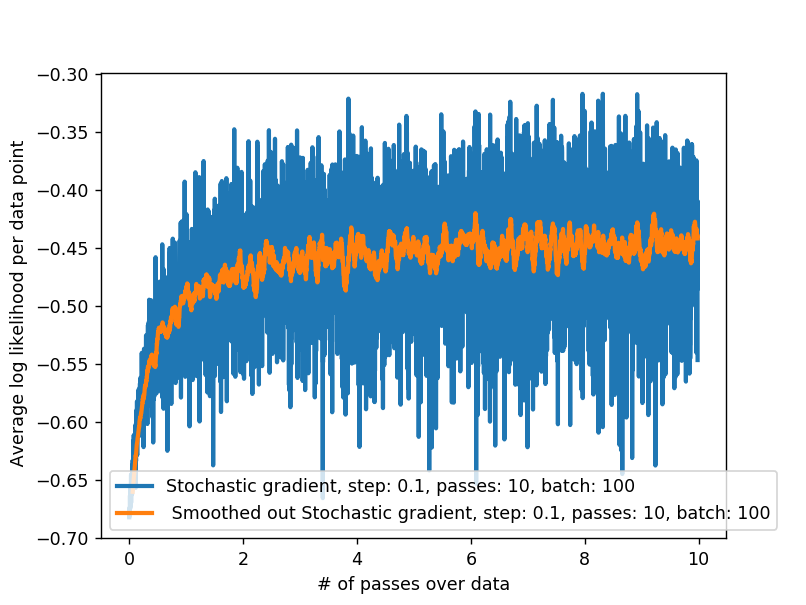

In [21]:
#test plot

make_plot(log_likelihood_100, len(X_train), 100, label='Stochastic gradient, step: 0.1, passes: 10, batch: 100')

make_plot(log_likelihood_100, len(X_train), 100, smoothing_window=30, label=' Smoothed out Stochastic gradient, step: 0.1, passes: 10, batch: 100')

<IPython.core.display.Javascript object>


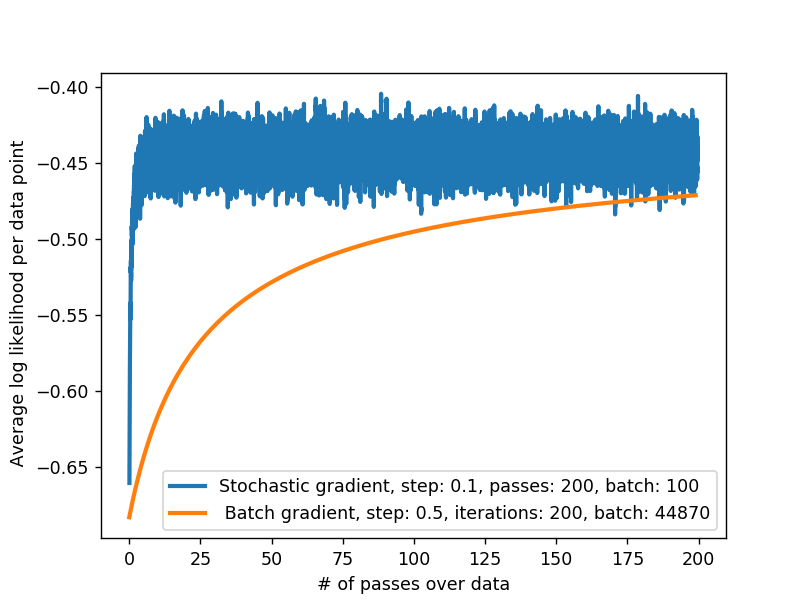

In [30]:
#stochastic first

passes=200
batch_S=100

iterations = passes * int(len(X_train) / batch_S)
coef_200, log_likelihood_200=logit_regression_SG(X_train, y_train, np.zeros(194),
                                  1e-1, batch_S, max_iter = iterations)

make_plot(log_likelihood_200, len(X_train), 100,smoothing_window=30, label='Stochastic gradient, step: 0.1, passes: 200, batch: 100')

# batch
#Batch
initial_W=np.zeros(194)
step_S=5e-1
batch_SS=len(X_train)
max_iter=200
coef_batch, log_batch = logit_regression_SG(X_train,y_train, initial_W,step_S,batch_SS,max_iter)

make_plot(log_batch, len(X_train), batch_SS ,smoothing_window=1, label=' Batch gradient, step: 0.5, iterations: 200, batch: 44870')

# Explore the effects of step sizes on stochastic gradient ascent


In [31]:
batch_S=100
passes=10
iterations= passes * int(len(X_train)/batch_S)
initial_W = np.zeros(194)


coeff ={}
log_hood={}
step_sizes= np.logspace(-4,2,num=7)
for step_size in step_sizes:
    coeff[step_size], log_hood[step_size] = logit_regression_SG(X_train, y_train, initial_W,
                                                               step_size, batch_S, iterations, verbose=False)

C:\Users\Keulando\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


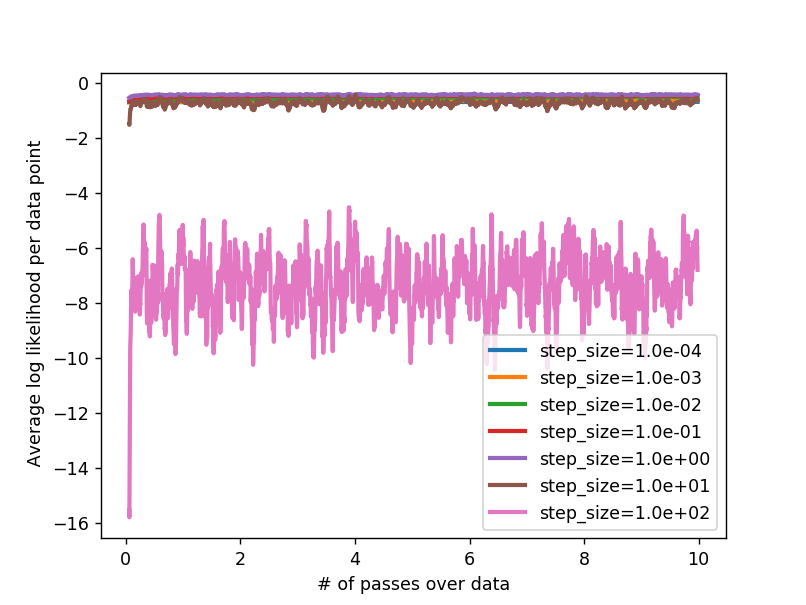

In [32]:
for step_size in step_sizes:
    make_plot(log_hood[step_size], len(X_train), batch_size=100,
              smoothing_window=30, label='step_size=%.1e'%step_size)